1. PatchEmbedding
2. IsometricEmbedding
3. Conv1dEmbedding(KernelSize 1)
4. Conv1dEmbedding(KernelSize seq_len)

In transformer-based time-series analysis, patch embedding could reduce the time computation.However,in ModernTCN it still uses patch-embedding with relatively small kernel size. To find whether patch embedding can affect the performance of the model, we set four experiments with different embedding methods. The first one is a common method with kernel size 4 and  stride size 2, and padding (P-S) is added at the end of the sequence.  

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics
from einops import rearrange

In [2]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [3]:
def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n

device = torch.device("cuda")
lr = 0.0001
epochs=300
loss=nn.CrossEntropyLoss()

P=4 S=2

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


epoch1,loss0.0019,train acc 0.810716,val acc 0.826
epoch2,loss0.0018,train acc 0.850021,val acc 0.853
epoch3,loss0.0017,train acc 0.870947,val acc 0.879
epoch4,loss0.0017,train acc 0.885162,val acc 0.893
epoch5,loss0.0016,train acc 0.892108,val acc 0.896
epoch6,loss0.0016,train acc 0.899561,val acc 0.900
epoch7,loss0.0016,train acc 0.904921,val acc 0.909
epoch8,loss0.0016,train acc 0.909664,val acc 0.906
epoch9,loss0.0016,train acc 0.915054,val acc 0.918
epoch10,loss0.0015,train acc 0.918189,val acc 0.916
epoch11,loss0.0015,train acc 0.920686,val acc 0.922
epoch12,loss0.0015,train acc 0.924048,val acc 0.927
epoch13,loss0.0015,train acc 0.926075,val acc 0.912
epoch14,loss0.0015,train acc 0.926640,val acc 0.914
epoch15,loss0.0015,train acc 0.930818,val acc 0.935
epoch16,loss0.0015,train acc 0.932382,val acc 0.934
epoch17,loss0.0015,train acc 0.932463,val acc 0.930
epoch18,loss0.0015,train acc 0.936780,val acc 0.938
epoch19,loss0.0015,train acc 0.937280,val acc 0.939
epoch20,loss0.0015,tr

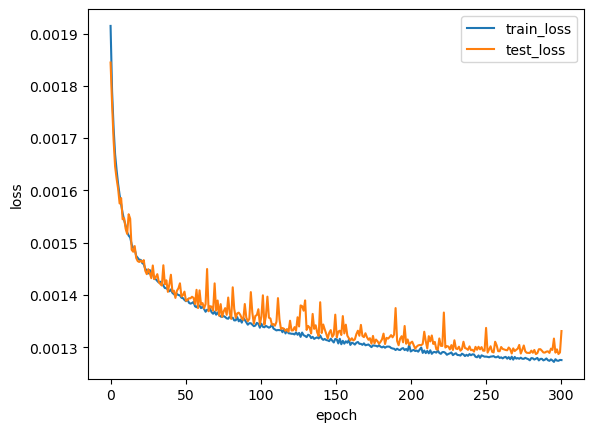

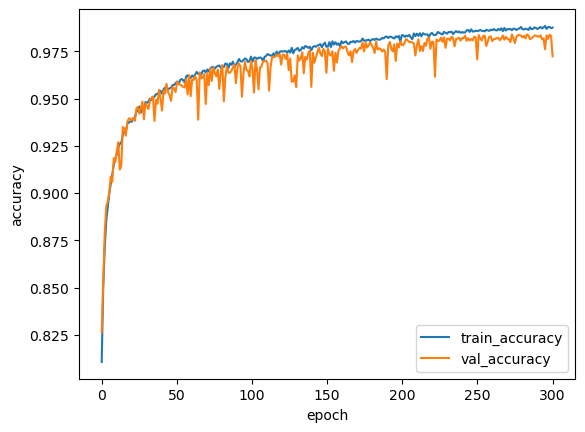

Accuracy on test set : 0.984
test precision: 0.9809775912612854  test recall: 0.97941282768685  test f1_score: 0.980110399522711


In [4]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=4,S=2):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        zeros = torch.zeros((x.shape[0], x.shape[1], self.P-self.S),device='cuda')
        x = torch.cat((x, zeros), dim=-1) #padding on the last 27
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        self.conv_b1 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b2 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b3 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b4 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y1 = self.conv_b1(x)
        y2 = self.conv_b2(x)
        y3 = self.conv_b3(x)
        y4 = self.conv_b4(x)
        y = y1 + y2 +y3 + y4 + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=variable_dim*seq_len*channel_dim//4),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//4,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em1_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em1_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=8 S=4

epoch1,loss0.0020,train acc 0.795340,val acc 0.804
epoch2,loss0.0018,train acc 0.845586,val acc 0.850
epoch3,loss0.0017,train acc 0.873304,val acc 0.875
epoch4,loss0.0017,train acc 0.886388,val acc 0.893
epoch5,loss0.0016,train acc 0.898805,val acc 0.907
epoch6,loss0.0016,train acc 0.908827,val acc 0.906
epoch7,loss0.0016,train acc 0.913071,val acc 0.917
epoch8,loss0.0015,train acc 0.914958,val acc 0.920
epoch9,loss0.0015,train acc 0.919210,val acc 0.921
epoch10,loss0.0015,train acc 0.921155,val acc 0.923
epoch11,loss0.0015,train acc 0.924900,val acc 0.928
epoch12,loss0.0015,train acc 0.926567,val acc 0.929
epoch13,loss0.0015,train acc 0.928748,val acc 0.916
epoch14,loss0.0015,train acc 0.930047,val acc 0.929
epoch15,loss0.0015,train acc 0.931472,val acc 0.931
epoch16,loss0.0015,train acc 0.932133,val acc 0.929
epoch17,loss0.0015,train acc 0.933909,val acc 0.935
epoch18,loss0.0015,train acc 0.935305,val acc 0.898
epoch19,loss0.0015,train acc 0.933851,val acc 0.930
epoch20,loss0.0015,tr

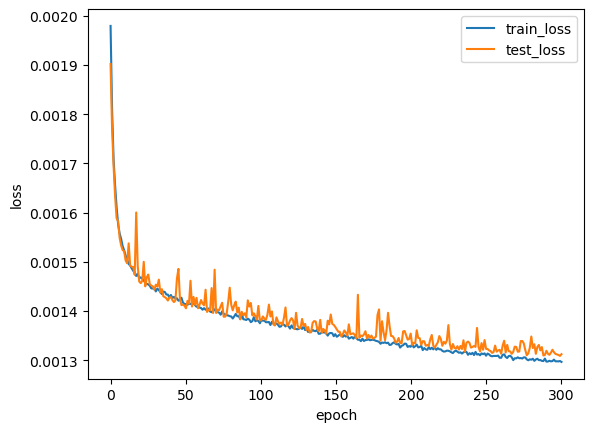

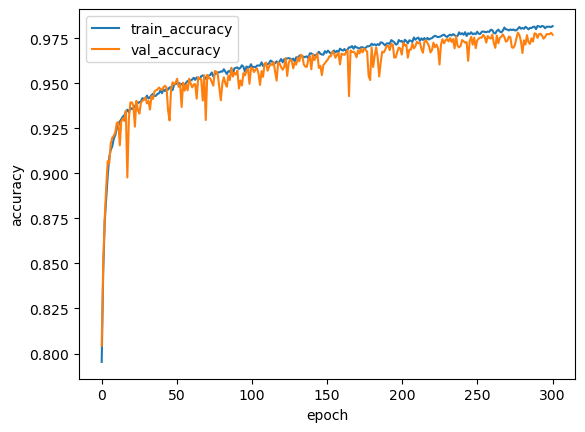

Accuracy on test set : 0.978
test precision: 0.9754289056664437  test recall: 0.9722705037180666  test f1_score: 0.9737283991374377


In [5]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=8,S=4):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        zeros = torch.zeros((x.shape[0], x.shape[1], self.P-self.S),device='cuda')
        x = torch.cat((x, zeros), dim=-1) #padding on the last 27
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        self.conv_b1 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b2 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b3 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b4 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y1 = self.conv_b1(x)
        y2 = self.conv_b2(x)
        y3 = self.conv_b3(x)
        y4 = self.conv_b4(x)
        y = y1 + y2 +y3 + y4 + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//4,out_features=variable_dim*seq_len*channel_dim//8),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//8,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em2_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em2_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=2 S=1

epoch1,loss0.0019,train acc 0.795583,val acc 0.817
epoch2,loss0.0018,train acc 0.842979,val acc 0.843
epoch3,loss0.0017,train acc 0.865345,val acc 0.876
epoch4,loss0.0017,train acc 0.880610,val acc 0.868
epoch5,loss0.0016,train acc 0.889450,val acc 0.901
epoch6,loss0.0016,train acc 0.897615,val acc 0.902
epoch7,loss0.0016,train acc 0.907293,val acc 0.908
epoch8,loss0.0016,train acc 0.913519,val acc 0.915
epoch9,loss0.0015,train acc 0.916772,val acc 0.915
epoch10,loss0.0015,train acc 0.920752,val acc 0.924
epoch11,loss0.0015,train acc 0.924357,val acc 0.910
epoch12,loss0.0015,train acc 0.927184,val acc 0.929
epoch13,loss0.0015,train acc 0.927690,val acc 0.932
epoch14,loss0.0015,train acc 0.931604,val acc 0.929
epoch15,loss0.0015,train acc 0.933006,val acc 0.929
epoch16,loss0.0015,train acc 0.934497,val acc 0.930
epoch17,loss0.0015,train acc 0.935738,val acc 0.934
epoch18,loss0.0015,train acc 0.935716,val acc 0.939
epoch19,loss0.0015,train acc 0.936898,val acc 0.934
epoch20,loss0.0015,tr

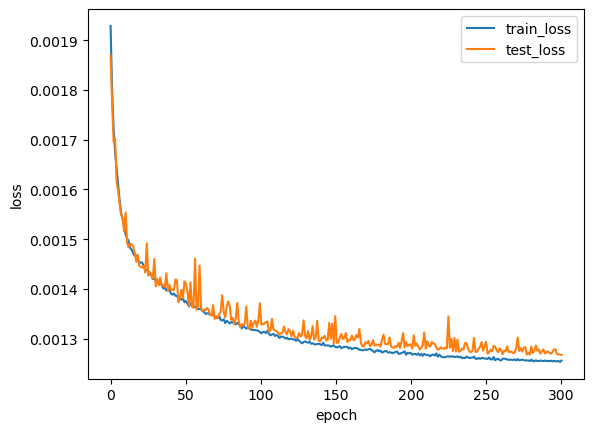

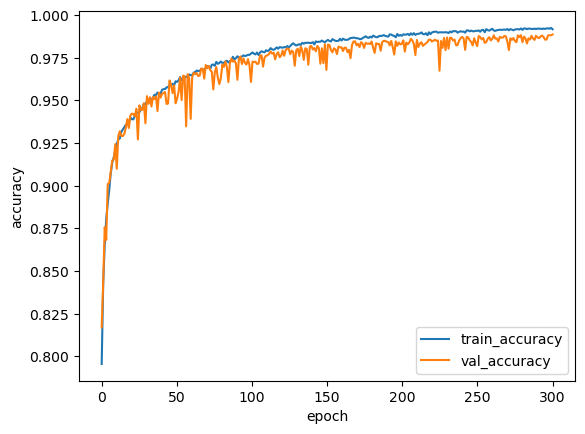

Accuracy on test set : 0.988
test precision: 0.9883050859443001  test recall: 0.9831702538777132  test f1_score: 0.9856755899351171


In [6]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=2,S=1):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        zeros = torch.zeros((x.shape[0], x.shape[1], self.P-self.S),device='cuda')
        x = torch.cat((x, zeros), dim=-1) #padding on the last 27
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        self.conv_b1 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b2 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b3 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b4 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y1 = self.conv_b1(x)
        y2 = self.conv_b2(x)
        y3 = self.conv_b3(x)
        y4 = self.conv_b4(x)
        y = y1 + y2 +y3 + y4 + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em3_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em3_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=4 S=4

epoch1,loss0.0020,train acc 0.787697,val acc 0.829
epoch2,loss0.0018,train acc 0.846562,val acc 0.862
epoch3,loss0.0017,train acc 0.865748,val acc 0.870
epoch4,loss0.0017,train acc 0.873539,val acc 0.878
epoch5,loss0.0017,train acc 0.883583,val acc 0.886
epoch6,loss0.0016,train acc 0.891440,val acc 0.892
epoch7,loss0.0016,train acc 0.896874,val acc 0.899
epoch8,loss0.0016,train acc 0.902057,val acc 0.900
epoch9,loss0.0016,train acc 0.905780,val acc 0.910
epoch10,loss0.0016,train acc 0.910648,val acc 0.914
epoch11,loss0.0016,train acc 0.913747,val acc 0.919
epoch12,loss0.0015,train acc 0.918255,val acc 0.919
epoch13,loss0.0015,train acc 0.920920,val acc 0.925
epoch14,loss0.0015,train acc 0.923813,val acc 0.921
epoch15,loss0.0015,train acc 0.926839,val acc 0.926
epoch16,loss0.0015,train acc 0.929276,val acc 0.932
epoch17,loss0.0015,train acc 0.930811,val acc 0.934
epoch18,loss0.0015,train acc 0.931237,val acc 0.936
epoch19,loss0.0015,train acc 0.934284,val acc 0.932
epoch20,loss0.0015,tr

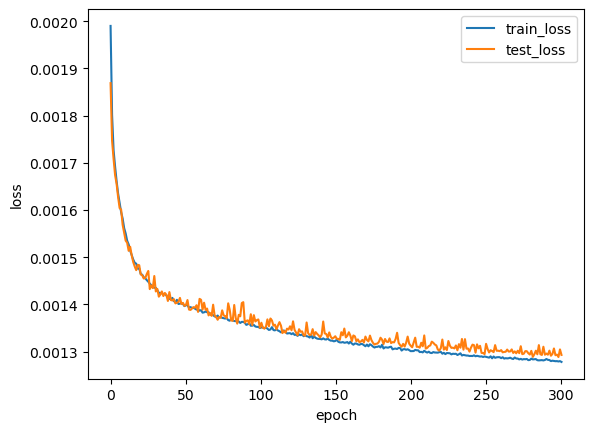

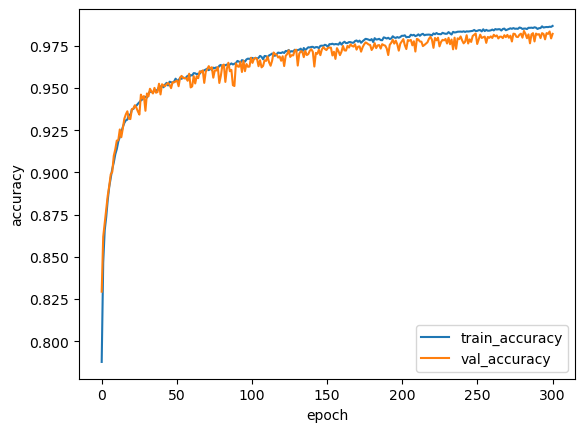

Accuracy on test set : 0.983
test precision: 0.9804415177118841  test recall: 0.9786889825193797  test f1_score: 0.9794674496413461


In [7]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=4,S=4):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        self.conv_b1 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b2 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b3 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b4 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim)        


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]
        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x        
        y1 = self.conv_b1(x)
        y2 = self.conv_b2(x)
        y3 = self.conv_b3(x)
        y4 = self.conv_b4(x)
        y = y1 + y2 +y3 + y4 + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//4,out_features=variable_dim*seq_len*channel_dim//8),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//8,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em4_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em4_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=2 S=2

epoch1,loss0.0019,train acc 0.800972,val acc 0.818
epoch2,loss0.0018,train acc 0.845857,val acc 0.864
epoch3,loss0.0017,train acc 0.879229,val acc 0.891
epoch4,loss0.0016,train acc 0.895075,val acc 0.896
epoch5,loss0.0016,train acc 0.903173,val acc 0.898
epoch6,loss0.0016,train acc 0.910935,val acc 0.916
epoch7,loss0.0015,train acc 0.917264,val acc 0.916
epoch8,loss0.0015,train acc 0.920854,val acc 0.918
epoch9,loss0.0015,train acc 0.925532,val acc 0.926
epoch10,loss0.0015,train acc 0.927455,val acc 0.931
epoch11,loss0.0015,train acc 0.929107,val acc 0.927
epoch12,loss0.0015,train acc 0.932301,val acc 0.931
epoch13,loss0.0015,train acc 0.934350,val acc 0.923
epoch14,loss0.0015,train acc 0.935752,val acc 0.932
epoch15,loss0.0015,train acc 0.936193,val acc 0.930
epoch16,loss0.0015,train acc 0.938638,val acc 0.939
epoch17,loss0.0015,train acc 0.939960,val acc 0.932
epoch18,loss0.0015,train acc 0.939409,val acc 0.937
epoch19,loss0.0014,train acc 0.941839,val acc 0.939
epoch20,loss0.0014,tr

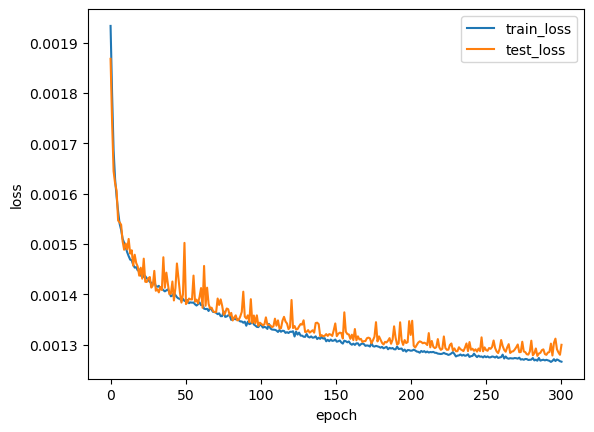

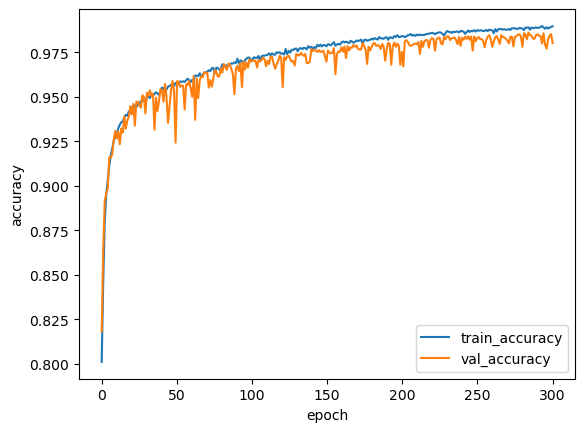

Accuracy on test set : 0.985
test precision: 0.9875601171483424  test recall: 0.9764773873737876  test f1_score: 0.981903735113401


In [8]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=2,S=2):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        self.conv_b1 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b2 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b3 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b4 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y1 = self.conv_b1(x)
        y2 = self.conv_b2(x)
        y3 = self.conv_b3(x)
        y4 = self.conv_b4(x)
        y = y1 + y2 +y3 + y4 + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=variable_dim*seq_len*channel_dim//4),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//4,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em5_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em5_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=1 S=1

epoch1,loss0.0020,train acc 0.756763,val acc 0.760
epoch2,loss0.0019,train acc 0.783335,val acc 0.846
epoch3,loss0.0018,train acc 0.855043,val acc 0.843
epoch4,loss0.0017,train acc 0.865433,val acc 0.877
epoch5,loss0.0017,train acc 0.876241,val acc 0.889
epoch6,loss0.0017,train acc 0.885676,val acc 0.891
epoch7,loss0.0016,train acc 0.893452,val acc 0.898
epoch8,loss0.0016,train acc 0.897711,val acc 0.901
epoch9,loss0.0016,train acc 0.905479,val acc 0.899
epoch10,loss0.0016,train acc 0.910399,val acc 0.917
epoch11,loss0.0015,train acc 0.916537,val acc 0.919
epoch12,loss0.0015,train acc 0.920429,val acc 0.926
epoch13,loss0.0015,train acc 0.923042,val acc 0.924
epoch14,loss0.0015,train acc 0.926560,val acc 0.927
epoch15,loss0.0015,train acc 0.926905,val acc 0.933
epoch16,loss0.0015,train acc 0.931134,val acc 0.930
epoch17,loss0.0015,train acc 0.933858,val acc 0.926
epoch18,loss0.0015,train acc 0.934313,val acc 0.942
epoch19,loss0.0015,train acc 0.933476,val acc 0.933
epoch20,loss0.0015,tr

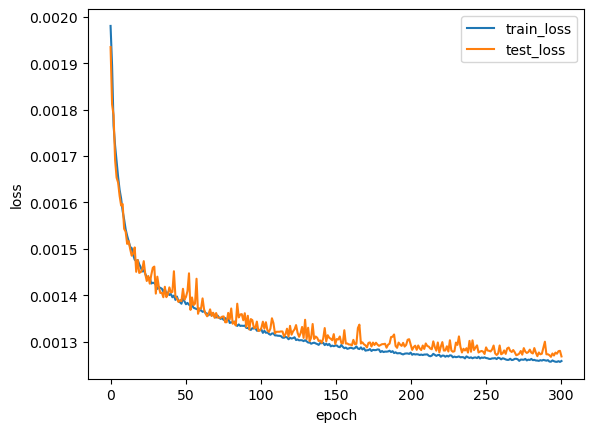

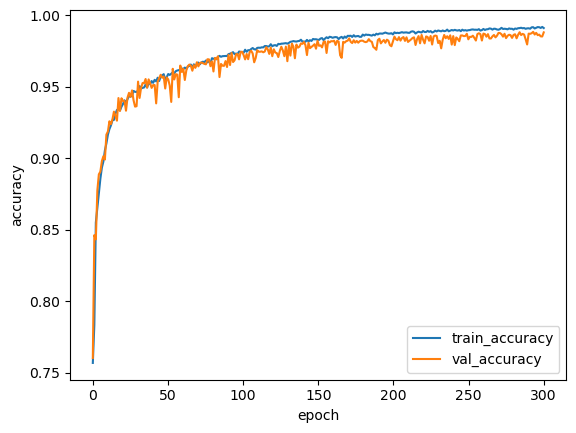

Accuracy on test set : 0.988
test precision: 0.9837194018679595  test recall: 0.9869895926310097  test f1_score: 0.9852788000863746


In [9]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=1,S=1):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        self.conv_b1 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b2 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b3 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b4 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y1 = self.conv_b1(x)
        y2 = self.conv_b2(x)
        y3 = self.conv_b3(x)
        y4 = self.conv_b4(x)
        y = y1 + y2 +y3 + y4 + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em6_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em6_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)